In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
from datetime import datetime
import numpy as np

Levantar el archivo de molinetes 2018, formatearlo y guardar solo la linea D ( se puede elegir que linea guardar)

In [130]:

mol_2018 = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Mol 2018.csv', sep=",")

mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018['Year'] = pd.DatetimeIndex(mol_2018['FECHA']).year

mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018['TOTAL'].fillna(0, inplace=True)
mol_2018.dropna(how='any', inplace=True)
mol_2018=mol_2018[mol_2018['MOLINETE'].apply(lambda x: "LINEA_D" in x )]


mol_2018.to_csv("Linea_D_sintwitt.csv", sep=';', encoding='utf-8')

Abrir el csv una vez guardado (si se corre antes el codigo de arriba y queda el df en la variable mol_2018 usar ese en vez de LIND, obviamente reemplazando LIND por mol_2018), formatearlo y juntar el del twitter

In [198]:
LIND = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Linea_D_sintwitt.csv', sep=";")

LIND['FECHA'] = pd.to_datetime(pd.Series(LIND['FECHA']), format="%Y/%m/%d")
LIND['DESDE'] =pd.to_datetime(pd.Series(LIND['DESDE']), format='%H:%M:%S')

#esto es para filtrar
#LIND[LIND['DESDE'] > datetime.strptime("08:00:00",'%X')]


TWD = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\TweetD.csv', sep=";")

TWD['DATE'] = pd.to_datetime(pd.Series(TWD['DATE']), format="%Y/%m/%d")
TWD['TIME'] =pd.to_datetime(pd.Series(TWD['TIME']), format='%H:%M:%S')

TWD.rename(columns={'DATE': 'FECHA'}, inplace=True)

#TWD.drop(['Unnamed: 0'],axis=1,inplace=True)
TWD.drop(['Linea D'],axis=1,inplace=True)
TWD.drop(['Demora'],axis=1,inplace=True)
TWD.drop(['Sinterrumpido'],axis=1,inplace=True)
TWD.drop(['Snormal'],axis=1,inplace=True)
TWD.drop(['Slimitado'],axis=1,inplace=True)
TWD.drop(['SdemFG'],axis=1,inplace=True)

TWD['Issuetype']=TWD['TEXT'].apply(lambda x: 'demora' if 'demora' in x else 'interrumpido' if 'interrumpido' in x else 'Normal' if 'frecuencia normal' in x else 'limitado' if 'limitado' in x else 'Normal')


def standdate(timestr):
    if (timestr.minute < 15 and timestr.minute >= 00):
        ab =(str('{:02d}'.format(timestr.hour)) + ":00:00")
    elif (timestr.minute >= 15 and timestr.minute < 30):
        ab =(str('{:02d}'.format(timestr.hour)) + ":15:00")
    elif (timestr.minute >= 30):
        ab = (str('{:02d}'.format(timestr.hour)) + ":30:00")

    return ab


TWD['DESDE'] = TWD['TIME'].map(standdate)
TWD['DESDE'] =pd.to_datetime(pd.Series(TWD['DESDE']), format='%H:%M:%S')

LINDTWD = pd.merge(LIND,TWD,how='left',on=['FECHA','DESDE'])

LINDTWD['WeekDay'] = LINDTWD['FECHA'].dt.strftime("%A")

#agrega el mean
BMOLmean= LINDTWD.groupby(['ESTACION','WeekDay','DESDE'], as_index=False)['TOTAL'].mean()
BMOLmean.rename(columns={'TOTAL': 'Mean'}, inplace=True)
LINDTWDmean = pd.merge(LINDTWD,BMOLmean,how='left',on=['ESTACION','WeekDay','DESDE'])


LINDTWDmean.to_csv("LineaDcontwit.csv", sep=';', encoding='utf-8')



C:\Users\alejandro.m.gizzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0_x,PERIODO,FECHA,DESDE,HASTA,LINEA,MOLINETE,ESTACION,TOTAL,Month,Unnamed: 0_y,TEXT,Datestamp,TIME,WeekDay,Issuetype
0,2969477,201805,2018-01-05,1900-01-01 08:00:00,08:15:00,LineaD,LineaD_Catedral_O_Turn04,Catedral,1.0,1,NaN,NaN,NaN,NaT,NaN,Normal
1,2969478,201805,2018-01-05,1900-01-01 08:00:00,08:15:00,LineaD,LineaD_CongresoTuc_O_Turn06,Congreso de Tucuman,5.0,1,NaN,NaN,NaN,NaT,NaN,Normal
2,2969479,201805,2018-01-05,1900-01-01 08:00:00,08:15:00,LineaD,LineaD_CongresoTuc_O_Turn08,Congreso de Tucuman,1.0,1,NaN,NaN,NaN,NaT,NaN,Normal
3,2969480,201805,2018-01-05,1900-01-01 08:00:00,08:15:00,LineaD,LineaD_FMedicina_N_Turn04,Facultad de Medicina,0.0,1,NaN,NaN,NaN,NaT,NaN,Normal
4,2969481,201805,2018-01-05,1900-01-01 08:00:00,08:15:00,LineaD,LineaD_J_Hernandez_Oeste_Turn03,Jose Hernandez,1.0,1,NaN,NaN,NaN,NaT,NaN,Normal


GRAFICOS (levantar LineaDcontwit.csv)

In [199]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from matplotlib.ticker import MaxNLocator
from collections import namedtuple



Total por mes

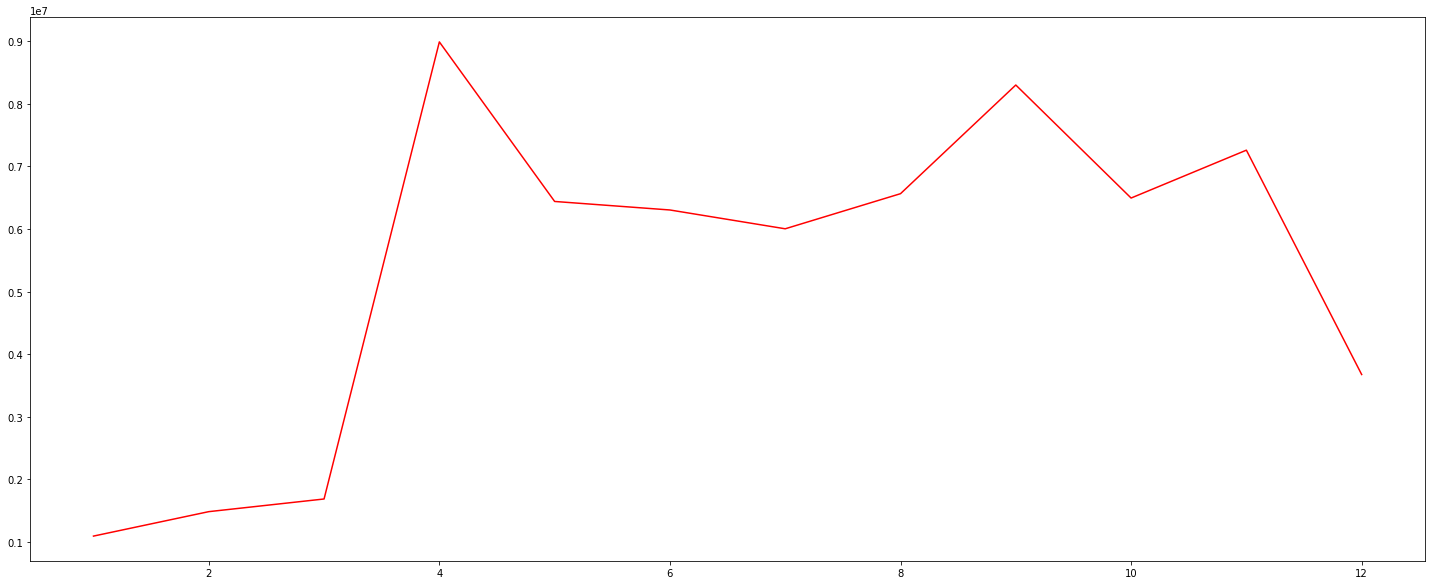

In [200]:
TotPag18 = LINDTWDmean
TotPag18.set_index(["Month"], inplace=True)
TotPag18 = TotPag18.sum(level=["Month"])

TotPag18 = TotPag18.reset_index()


fig, ax = plt.subplots(figsize=(25,10))
ax.plot(TotPag18['Month'], TotPag18['TOTAL'], color='r')
plt.show()


Por dia

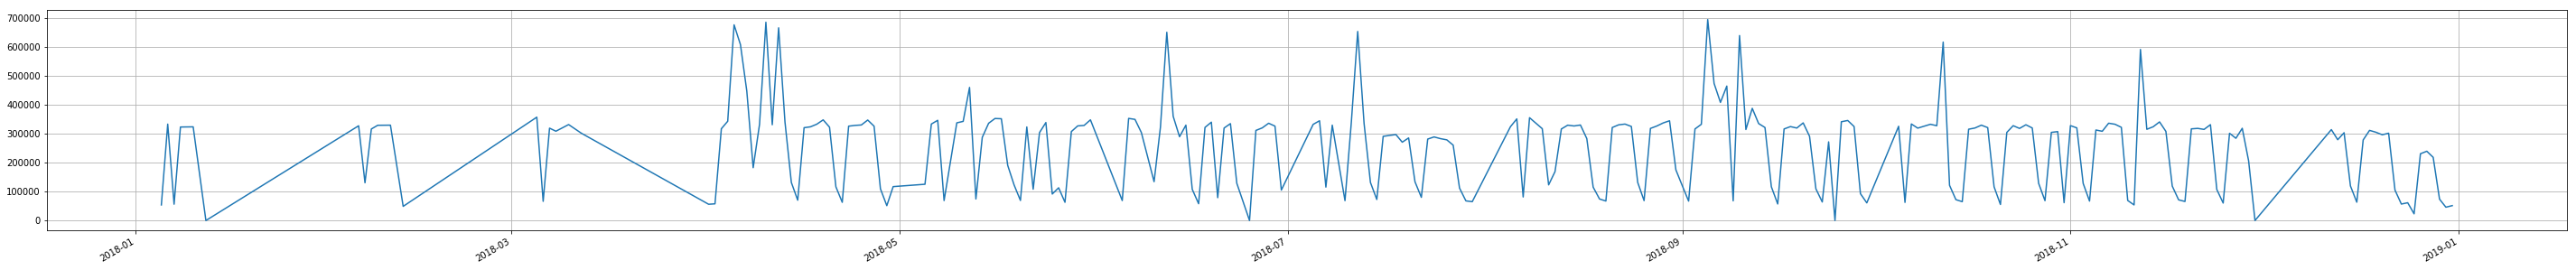

In [201]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["FECHA"], inplace=True)
TotPag18 = TotPag18.sum(level=["FECHA"])

TotPag18 = TotPag18.reset_index()

TotPag18= TotPag18.sort_values(by='FECHA')


#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(50,5))
ax.plot(TotPag18['FECHA'], TotPag18['TOTAL'])


ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

Por Estacion

In [235]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["ESTACION"], inplace=True)
TotPag18 = TotPag18.sum(level=["ESTACION"])

TotPag18 = TotPag18.reset_index()

#TotPag18= TotPag18.sort_values(by='FECHA')



GRAFICO PIE

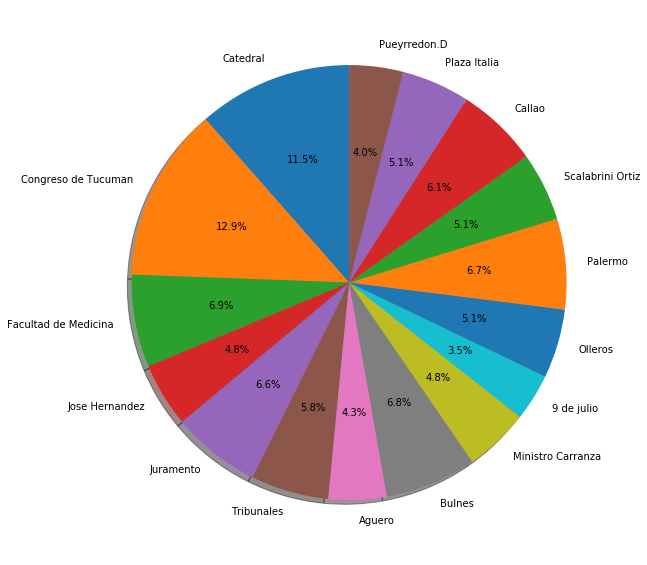

In [233]:
# Pie chart solo 
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')



fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     


#fig.tight_layout()

plt.show()

                            
                 

GRAFICO DE BARRAS

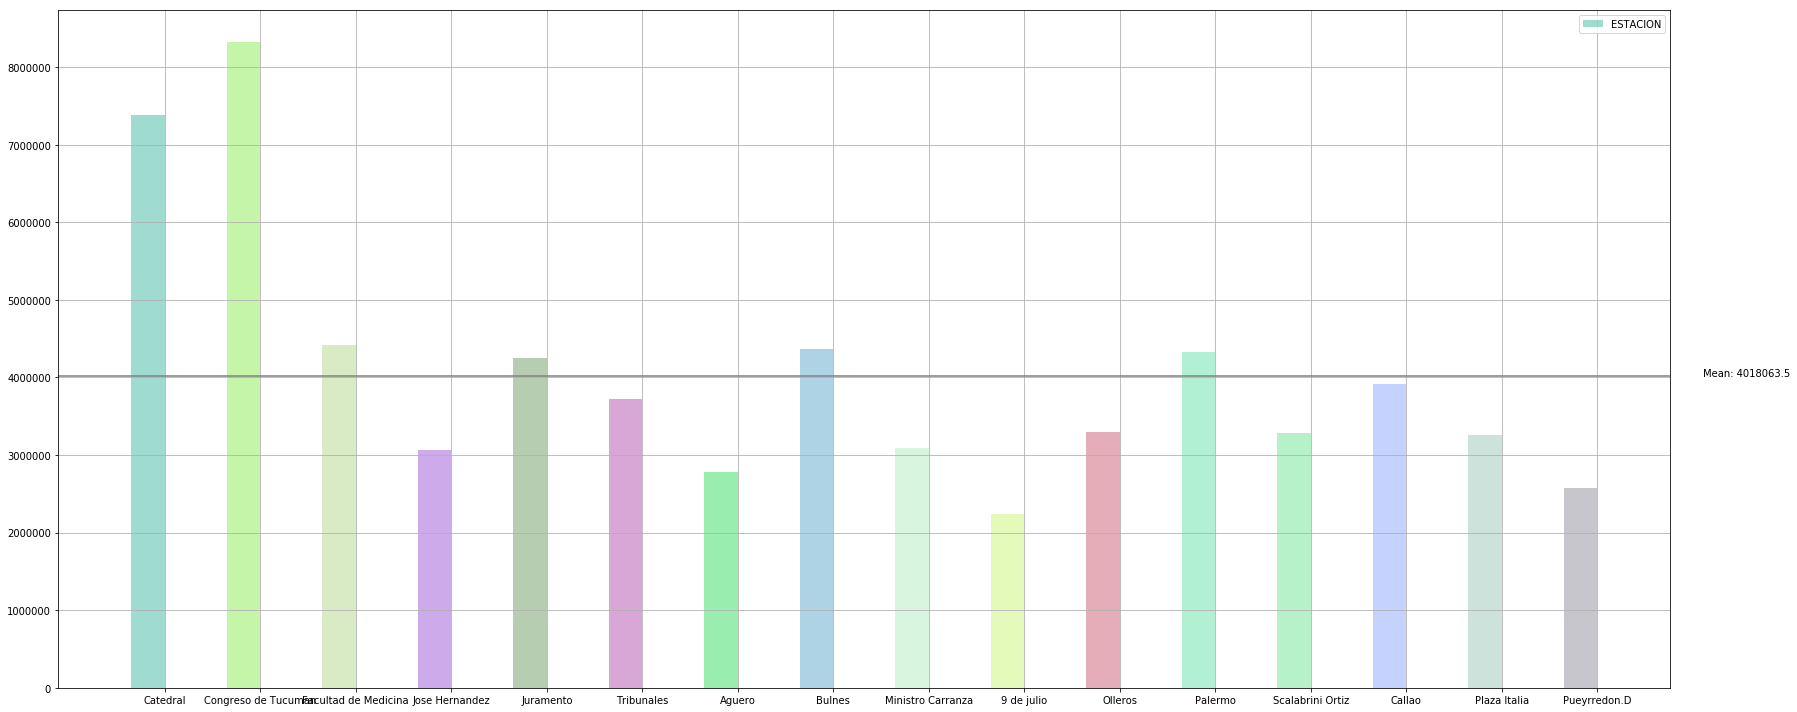

In [263]:
#BAR SOLO
#https://webcache.googleusercontent.com/search?q=cache:WY7G0y4OxQ8J:https://stackoverflow.com/questions/43560801/display-y-axis-value-horizontal-line-drawn-in-bar-chart+&cd=4&hl=es-419&ct=clnk&gl=ar
import matplotlib.colors
fig, ax = plt.subplots(figsize=(25,10))

index = np.arange(TotPag18.ESTACION.count())

bar_width = 0.35
opacity = 0.4

norm = matplotlib.colors.Normalize(30e3, 60e3)
ax.bar(index,TotPag18.TOTAL, bar_width,alpha=opacity,
       color=np.random.rand ( 256,3),
       label='ESTACION')


#rects1 = ax.bar(index, TotPag18.TOTAL, bar_width,
#                alpha=opacity, color='b',
#                label='ESTACION')

#rects2 = ax.bar(index + bar_width, means_women, bar_width,
#                alpha=opacity, color='r',
#                yerr=std_women, error_kw=error_config,
#                label='Women')

#ax.set_xlabel('Group')
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.axhline(TotPag18.TOTAL.mean(), color="gray")
ax.grid(True)
ax.text(1.02, TotPag18.TOTAL.mean(), "Mean: " + str(TotPag18.TOTAL.mean()),transform=ax.get_yaxis_transform())
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(TotPag18.ESTACION)
ax.legend()

fig.tight_layout()
plt.show()

BARRAS Y PIE

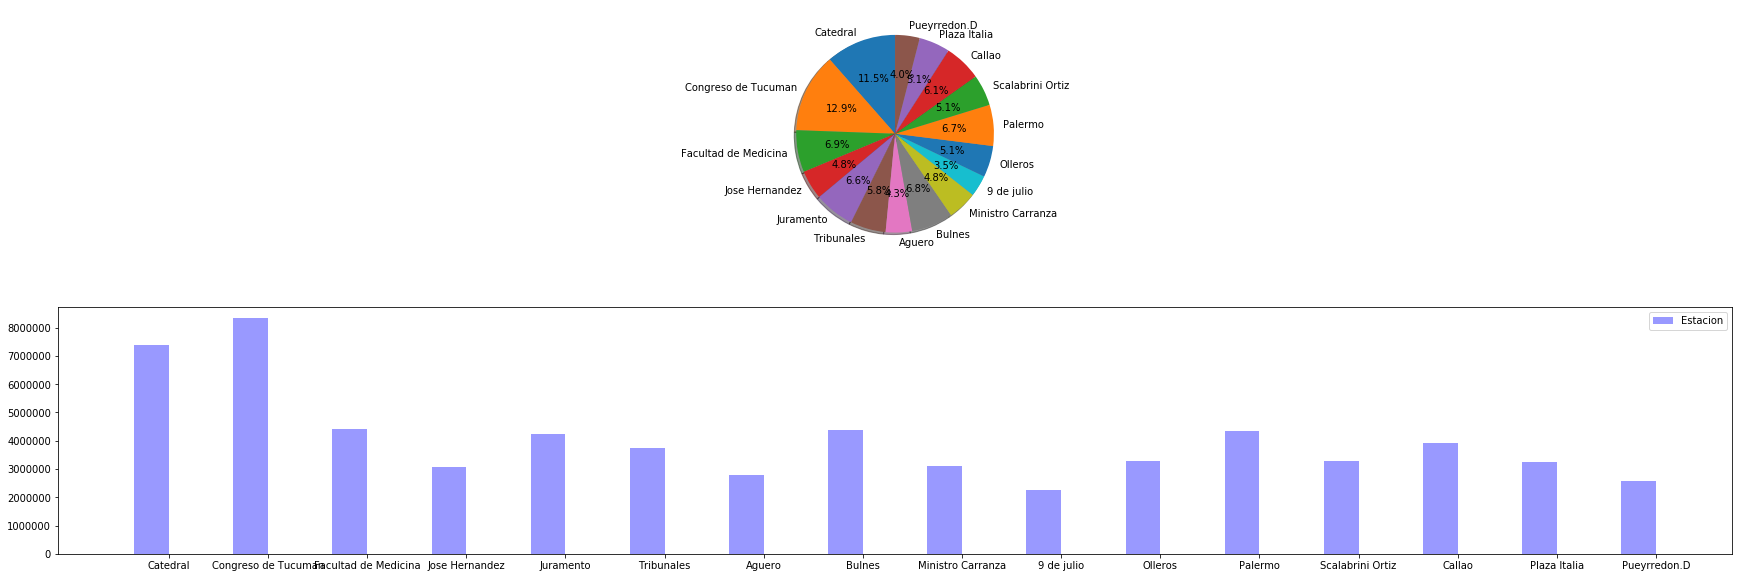

In [234]:
# Pie chart
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(TotPag18.ESTACION.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,10))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, TotPag18.TOTAL, bar_width,
                alpha=opacity, color='b',
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(TotPag18.ESTACION)
axs[1].legend()


#fig.tight_layout()

plt.show()

                            
                 

In [210]:

#limpiar las estaciones que estan mal
#LINDTWD['ESTACION']=LINDTWD['ESTACION'].apply(lambda x: 'Aguero' if 'Agüero' in x else x)
#LINDTWD.ESTACION.unique()


In [188]:
#esto es otro subset que hice para probar algo, no es necesario correrlo
mol_2018 = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Mol 2018.csv', sep=",")
mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018 = mol_2018[mol_2018.MOLINETE.apply(lambda x: 'LineaD' in x)]


#mol_2018['TOTAL'].fillna(0, inplace=True)


mol_2018.dropna(how='any', inplace=True)
mol_2018.to_csv("Linea_D_sintwitt2.csv", sep=';', encoding='utf-8')



array(['LineaD'], dtype=object)

PLOTLY GRAFICOS (MAS DINAMICOS)

In [296]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
from datetime import datetime

df = LINDTWDmean
#cambiar la ruta de donde esta el archivo
#df = pd.read_csv('/home/ale/Documents/TP FINAL/Areadytoplot.csv', sep=";")
#df['FECHA'] = pd.to_datetime(df['FECHA'])
#df['ESTACION'] = df['ESTACION'].astype('str')
#df['DESDE'] = pd.to_datetime(pd.Series(df['DESDE']), format='%H:%M:%S')

#jueguen con esto para ir filtrando el dataset
sdf = df[(df['ESTACION'] =='Catedral') &  (df['FECHA'] >='2018-05-01')]

#https://stackoverflow.com/questions/51181729/custom-plotly-markers-based-on-variable-value
def SetColor(x):
    if(x !='Normal'):
        return "red"
    else:
        return "green"

def Setsize(x):
    if(x !='Normal'):
        return 40
    else:
        return 5
    
#https://plot.ly/python/figure-labels/
#https://plot.ly/python/offline/
data = [go.Scatter(x=sdf.DESDE,y=sdf['TOTAL'],mode ='lines+markers',
                   name="Total horario",
                   text=sdf['TEXT'],
                   marker = dict(color=list(map(SetColor, sdf['Issuetype'])),
                                size=list(map(Setsize, sdf['Issuetype'])))),
        go.Scatter(x=sdf.DESDE,y=sdf['Mean'].apply(np.round),name="Mean")]

py.iplot(data)

OSError: [Errno 22] Invalid argument